# **Modul 6 AI LLM**

---

**Nama**: Michael Kenneth Salim <br>
**NRP**: 5027231008

## **Import Library**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import re
import string
import os
import subprocess

import torch
import torch.utils.data as data

from IPython.display import FileLink, display
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction, DataCollatorWithPadding
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from huggingface_hub import login

2025-06-16 13:38:47.383778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750081127.597518      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750081127.659232      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **EDA**

In [2]:
df_train = pd.read_csv('/kaggle/input/test-and-train/train.csv')
df_test = pd.read_csv('/kaggle/input/test-and-train/test.csv')

In [3]:
df_train.head(5)

,text,amusement,anger,annoyance,caring,confusion,disappointment,disgust,embarrassment,excitement,fear,gratitude,joy,love,sadness
0,And if they can't find US suckers to give them...,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,Definitely teased you ;) I think it was punish...,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Probably nothing. I'm assuming they're disputi...,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,"Regardless, fight 'em every inch of the way li...",0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Define woman please if you're not going to use...,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df_test.head(5)

,id,text
0,oupyc,Now I can’t unhear it...
1,eylly,I post on the the Donald you think I give a fa...
2,bnmji,"Unlikely, but who knows? Memory speed rarely m..."
3,zmker,Is it possible you've been banned from them? I...
4,36lqo,You're in for a treat- enjoy :)


In [5]:
df_train.isnull().sum()

text              0
amusement         0
anger             0
annoyance         0
caring            0
confusion         0
disappointment    0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
joy               0
love              0
sadness           0
dtype: int64

In [6]:
df_test.isnull().sum()

id      0
text    0
dtype: int64

### **Visualization**

In [3]:
emotion_columns = ['amusement', 'anger', 'annoyance', 'caring', 'confusion',
                   'disappointment', 'disgust', 'embarrassment', 'excitement',
                   'fear', 'gratitude', 'joy', 'love', 'sadness']

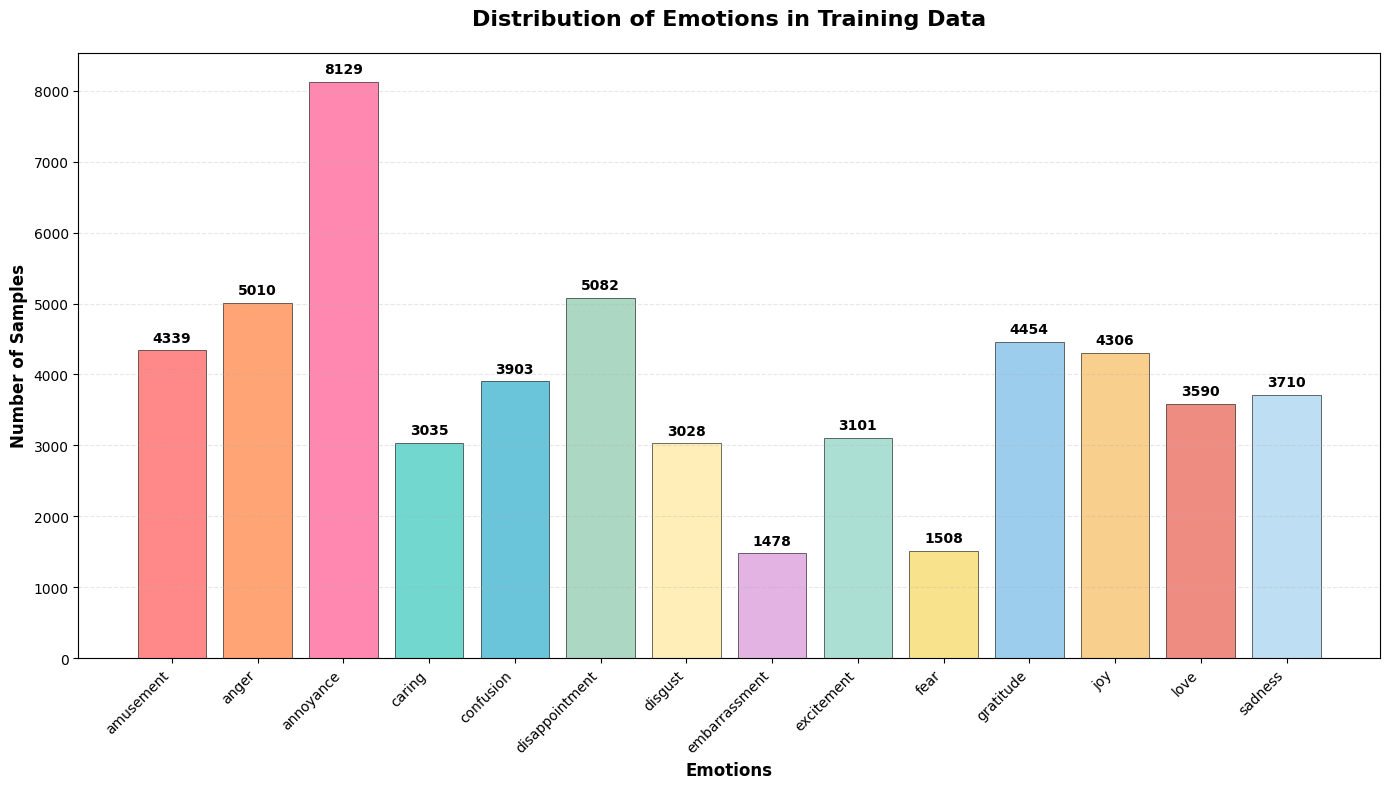

In [8]:
emotion_counts = df_train[emotion_columns].sum()

plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#FF8E53', '#FF6B9D', '#4ECDC4', '#45B7D1',
          '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F',
          '#85C1E9', '#F8C471', '#EC7063', '#AED6F1']

bars = plt.bar(range(len(emotion_counts)), emotion_counts.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Emotions', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Emotions in Training Data', fontsize=16, fontweight='bold', pad=20)

plt.xticks(range(len(emotion_counts)), emotion_counts.index, rotation=45, ha='right')

for i, (emotion, count) in enumerate(zip(emotion_counts.index, emotion_counts.values)):
    plt.text(i, count + max(emotion_counts.values) * 0.01, str(count),
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## **Data Pre-Processing**

In [4]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [5]:
df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

In [6]:
df_train[['text', 'cleaned_text']][:15]

,text,cleaned_text
0,And if they can't find US suckers to give them...,And if they cant find US suckers to give them ...
1,Definitely teased you ;) I think it was punish...,Definitely teased you I think it was punishmen...
2,Probably nothing. I'm assuming they're disputi...,Probably nothing Im assuming theyre disputing ...
3,"Regardless, fight 'em every inch of the way li...",Regardless fight em every inch of the way like...
4,Define woman please if you're not going to use...,Define woman please if youre not going to use ...
5,at sunset i want to bang my wife there on the ...,at sunset i want to bang my wife there on the ...
6,Especially the Lexus peeps. Just baffles me ho...,Especially the Lexus peeps Just baffles me how...
7,I'm crying laughing in the cubes.,Im crying laughing in the cubes
8,OMG she's BYEsexual. Sorry I had to.,OMG shes BYEsexual Sorry I had to
9,"NSFW tagged for showing [NAME]. But anyways, I...",NSFW tagged for showing NAME But anyways I hop...


### **Split**

In [7]:
class EmotionDataset(data.Dataset):

    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

In [8]:
X = df_train['cleaned_text'].values
y = df_train[emotion_columns].values

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [15]:
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(df_test)}")

Train size: 37164
Validation size: 9291
Test size: 8199


In [10]:
idtolabel = {i: label for i, label in enumerate(emotion_columns)}
labeltoid = {label: i for i, label in enumerate(emotion_columns)}
num_labels = len(emotion_columns)

In [11]:
login()

## **Initiate 1st Model**

Pada model pertama ini, pretrained model yang digunakan dalam modul 6 ini adalah `google-bert/bert-base-cased`. Mengapa? Karena pretrained model ini sudah dilatih menggunakan kumpulan data berbahasa Inggris secara self-supervised. Ini berarti BERT dilatih hanya dengan teks mentah, tanpa pelabelan oleh manusia sama sekali, dimana hal ini memberikan BERT pemahaman yang mendalam tentang struktur, tata bahasa, dan konteks kata-kata dalam bahasa Inggris. Ditambah lagi, model cased lebih dipilih karena *case sensitive* alias sensitif terhadap huruf besar dan kecil.

In [16]:
model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
max_length = 256

train_data = EmotionDataset(X_train, y_train, tokenizer, max_length)
val_data = EmotionDataset(X_val, y_val, tokenizer, max_length)

test_data = EmotionDataset(df_test['cleaned_text'].values, None, tokenizer, max_length)

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=idtolabel,
    label2id=labeltoid,
)

print(f"Model initialized with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 108.3M parameters
Device: cuda


In [28]:
training_args = TrainingArguments(
    output_dir='./emotion_classifier',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=True,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    report_to=[],
    hub_model_id="KenetHilang/emotion-classifier",
)

In [29]:
def compute_metrics(eval_pred: EvalPrediction):
    predictions, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels

    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    return {
        'f1': f1_micro,
        'f1_macro': f1_macro,
    }

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("Trainer initialized successfully!")

Trainer initialized successfully!


In [31]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,F1 Macro
1,0.207400,0.204342,0.344865,0.281697
2,0.190800,0.196065,0.386231,0.340443
3,0.176100,0.196734,0.414975,0.382843


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3486, training_loss=0.2193623415300782, metrics={'train_runtime': 3115.1814, 'train_samples_per_second': 35.79, 'train_steps_per_second': 1.119, 'total_flos': 1.4668969202896896e+16, 'train_loss': 0.2193623415300782, 'epoch': 3.0})

## **Initiate 2nd Model**

Pada model kedua ini, pretrained model yang digunakan dalam modul 6 adalah `distilbert-base-uncased`. Hal ini dikarenakan DistilBERT adalah model transformer yang lebih kecil dan lebih cepat dari BERT, dan dilatih menggunakan kumpulan data yang sama. Sama seperti pretrained sebelumnya, DistilBERT dilatih hanya dengan teks mentah, tanpa pelabelan oleh manusia sama sekali. Lebih jelasnya, DistilBERT dilatih dengan tiga tujuan, salah satunya adalah Distillation loss, di mana model dilatih untuk menghasilkan probabilitas yang sama dengan model BERT base. Alasan kedua mengapa model ini dipilih adalah sebuah percobaan untuk melihat apakah *case-sensitive* bisa mempengaruhi hasil dari model yang telah di fine tune ini.

In [18]:
model_name_2 = 'distilbert-base-uncased'
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)

In [33]:
max_length = 256

train_data_2 = EmotionDataset(X_train, y_train, tokenizer_2, max_length)
val_data_2 = EmotionDataset(X_val, y_val, tokenizer_2, max_length)

test_data_2 = EmotionDataset(df_test['cleaned_text'].values, None, tokenizer_2, max_length)

In [20]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    model_name_2,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=idtolabel,
    label2id=labeltoid,
)

print(f"Model initialized with {sum(p.numel() for p in model_2.parameters())/1e6:.1f}M parameters")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 67.0M parameters
Device: cuda


In [35]:
training_args_2 = TrainingArguments(
    output_dir='./emotion_classifier_2',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=True,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    report_to=[],
    hub_model_id="KenetHilang/emotion-classifier_2",
)

In [36]:
data_collator_2 = DataCollatorWithPadding(tokenizer=tokenizer_2)

trainer_2 = Trainer(
    model=model_2,
    args=training_args_2,
    train_dataset=train_data_2,
    eval_dataset=val_data_2,
    compute_metrics=compute_metrics,
    data_collator=data_collator_2,
)

print("2nd Trainer initialized successfully!")

2nd Trainer initialized successfully!


In [37]:
trainer_2.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,F1 Macro
1,0.207900,0.203203,0.327110,0.262936
2,0.193400,0.195501,0.367084,0.319504
3,0.180300,0.195237,0.405911,0.369238


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3486, training_loss=0.2220929909627874, metrics={'train_runtime': 1621.0796, 'train_samples_per_second': 68.776, 'train_steps_per_second': 2.15, 'total_flos': 7386107916275712.0, 'train_loss': 0.2220929909627874, 'epoch': 3.0})

## **Initiate 3rd Model**

In [22]:
model_name_3 = 'distilbert-base-cased'
tokenizer_3 = AutoTokenizer.from_pretrained(model_name_3)

In [23]:
train_data_3 = EmotionDataset(X_train, y_train, tokenizer_3, max_length)
val_data_3 = EmotionDataset(X_val, y_val, tokenizer_3, max_length)

test_data_3 = EmotionDataset(df_test['cleaned_text'].values, None, tokenizer_3, max_length)

In [25]:
model_3 = AutoModelForSequenceClassification.from_pretrained(
    model_name_3,
    num_labels=num_labels,
    problem_type="multi_label_classification",
    id2label=idtolabel,
    label2id=labeltoid,
)

print(f"Model initialized with {sum(p.numel() for p in model_3.parameters())/1e6:.1f}M parameters")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized with 65.8M parameters
Device: cuda


In [41]:
training_args_3 = TrainingArguments(
    output_dir='./emotion_classifier_3',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    push_to_hub=True,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    greater_is_better=True,
    report_to=[],
    hub_model_id="KenetHilang/emotion-classifier_3",
)

In [42]:
data_collator_3 = DataCollatorWithPadding(tokenizer=tokenizer_3)

trainer_3 = Trainer(
    model=model_3,
    args=training_args_3,
    train_dataset=train_data_3,
    eval_dataset=val_data_3,
    compute_metrics=compute_metrics,
    data_collator=data_collator_3,
)

print("3rd Trainer initialized successfully!")

3rd Trainer initialized successfully!


In [70]:
trainer_3.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,F1 Macro
1,0.182300,0.199365,0.407026,0.377341
2,0.185200,0.198835,0.399605,0.374032
3,0.163700,0.204018,0.415502,0.393219


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3486, training_loss=0.17707153770065964, metrics={'train_runtime': 3277.1765, 'train_samples_per_second': 34.021, 'train_steps_per_second': 1.064, 'total_flos': 1.5026607666929664e+16, 'train_loss': 0.17707153770065964, 'epoch': 3.0})

## **Generate Test Predictions for Kaggle**

### **1st Test**

In [49]:
val_preds = trainer.predict(val_data)
val_logits = val_preds.predictions
val_true_labels = val_preds.label_ids

val_probs = 1 / (1 + np.exp(-val_logits))

best_thresholds = []
for i in tqdm(range(len(emotion_columns)), desc="Finding Label-Specific Thresholds"):
    thresholds = np.arange(0.05, 0.95, 0.01)
    f1s = [f1_score(val_true_labels[:, i], (val_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    best_t_index = np.argmax(f1s)
    best_t = thresholds[best_t_index]
    best_thresholds.append(best_t)
    print(f"Best threshold for '{emotion_columns[i]}': {best_t:.2f} (F1: {f1s[best_t_index]:.4f})")

best_thresholds = np.array(best_thresholds)

val_preds_optimal = (val_probs > best_thresholds).astype(int)
best_f1_score = f1_score(val_true_labels, val_preds_optimal, average='macro', zero_division=0)

print(f"\nBest F1-macro score for 1st Model: {best_f1_score:.4f}")

Finding Label-Specific Thresholds:   7%|▋         | 1/14 [00:00<00:05,  2.40it/s]

Best threshold for 'amusement': 0.31 (F1: 0.6494)


Finding Label-Specific Thresholds:  14%|█▍        | 2/14 [00:00<00:05,  2.26it/s]

Best threshold for 'anger': 0.32 (F1: 0.4604)


Finding Label-Specific Thresholds:  21%|██▏       | 3/14 [00:01<00:04,  2.32it/s]

Best threshold for 'annoyance': 0.23 (F1: 0.4550)


Finding Label-Specific Thresholds:  29%|██▊       | 4/14 [00:01<00:04,  2.23it/s]

Best threshold for 'caring': 0.23 (F1: 0.4620)


Finding Label-Specific Thresholds:  36%|███▌      | 5/14 [00:02<00:04,  2.08it/s]

Best threshold for 'confusion': 0.22 (F1: 0.5296)


Finding Label-Specific Thresholds:  43%|████▎     | 6/14 [00:02<00:03,  2.10it/s]

Best threshold for 'disappointment': 0.18 (F1: 0.3646)


Finding Label-Specific Thresholds:  50%|█████     | 7/14 [00:03<00:03,  2.13it/s]

Best threshold for 'disgust': 0.17 (F1: 0.3333)


Finding Label-Specific Thresholds:  57%|█████▋    | 8/14 [00:03<00:02,  2.17it/s]

Best threshold for 'embarrassment': 0.12 (F1: 0.3018)


Finding Label-Specific Thresholds:  64%|██████▍   | 9/14 [00:04<00:02,  2.15it/s]

Best threshold for 'excitement': 0.29 (F1: 0.4058)


Finding Label-Specific Thresholds:  71%|███████▏  | 10/14 [00:04<00:01,  2.16it/s]

Best threshold for 'fear': 0.20 (F1: 0.4831)


Finding Label-Specific Thresholds:  79%|███████▊  | 11/14 [00:05<00:01,  2.11it/s]

Best threshold for 'gratitude': 0.38 (F1: 0.7885)


Finding Label-Specific Thresholds:  86%|████████▌ | 12/14 [00:05<00:00,  2.14it/s]

Best threshold for 'joy': 0.21 (F1: 0.4811)


Finding Label-Specific Thresholds:  93%|█████████▎| 13/14 [00:06<00:00,  2.12it/s]

Best threshold for 'love': 0.40 (F1: 0.7259)


Finding Label-Specific Thresholds: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]

Best threshold for 'sadness': 0.27 (F1: 0.4578)

Best F1-macro score for 1st Model: 0.4927


In [65]:
print("Making predictions on the test set...")
test_predictions = trainer.predict(test_data)
test_logits = test_predictions.predictions

test_probs = 1 / (1 + np.exp(-test_logits))
binary_predictions = (test_probs > best_thresholds).astype(int)

submission_df = df_test[['id']].copy()

labels_list = []
for i in range(len(binary_predictions)):
    positive_indices = np.where(binary_predictions[i] == 1)[0]
    
    if len(positive_indices) == 0:
        positive_indices = [np.argmax(test_probs[i])]
        
    labels_str = ' '.join(map(str, positive_indices))
    labels_list.append(labels_str)

submission_df['labels'] = labels_list

print("\nSubmission preview:")
display(submission_df.head(10))

submission_df.to_csv('submission_final.csv', index=False)

Making predictions on the test set...



Submission preview:


,id,labels
0,oupyc,5
1,eylly,1 2
2,bnmji,4
3,zmker,0 4
4,36lqo,11
5,0hxiw,2 4
6,uptia,11
7,mhsiz,1 2 6
8,fe876,5 13
9,7mg43,8


### **2nd Test**

In [67]:
val_preds = trainer_2.predict(val_data_2 )
val_logits = val_preds.predictions
val_true_labels = val_preds.label_ids

val_probs = 1 / (1 + np.exp(-val_logits))

best_thresholds = []
for i in tqdm(range(len(emotion_columns)), desc="Finding Label-Specific Thresholds"):
    thresholds = np.arange(0.05, 0.95, 0.01)
    f1s = [f1_score(val_true_labels[:, i], (val_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    best_t_index = np.argmax(f1s)
    best_t = thresholds[best_t_index]
    best_thresholds.append(best_t)
    print(f"Best threshold for '{emotion_columns[i]}': {best_t:.2f} (F1: {f1s[best_t_index]:.4f})")

best_thresholds = np.array(best_thresholds)

val_preds_optimal = (val_probs > best_thresholds).astype(int)
best_f1_score = f1_score(val_true_labels, val_preds_optimal, average='macro', zero_division=0)

print(f"\nBest F1-macro score for 2nd Model: {best_f1_score:.4f}")

ERROR! Session/line number was not unique in database. History logging moved to new session 29


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
Finding Label-Specific Thresholds:   7%|▋         | 1/14 [00:00<00:05,  2.46it/s]

Best threshold for 'amusement': 0.36 (F1: 0.6488)


Finding Label-Specific Thresholds:  14%|█▍        | 2/14 [00:00<00:05,  2.28it/s]

Best threshold for 'anger': 0.28 (F1: 0.4511)


Finding Label-Specific Thresholds:  21%|██▏       | 3/14 [00:01<00:04,  2.30it/s]

Best threshold for 'annoyance': 0.17 (F1: 0.4554)


Finding Label-Specific Thresholds:  29%|██▊       | 4/14 [00:01<00:04,  2.19it/s]

Best threshold for 'caring': 0.31 (F1: 0.4600)


Finding Label-Specific Thresholds:  36%|███▌      | 5/14 [00:02<00:04,  2.13it/s]

Best threshold for 'confusion': 0.22 (F1: 0.5261)


Finding Label-Specific Thresholds:  43%|████▎     | 6/14 [00:02<00:03,  2.18it/s]

Best threshold for 'disappointment': 0.19 (F1: 0.3552)


Finding Label-Specific Thresholds:  50%|█████     | 7/14 [00:03<00:03,  2.22it/s]

Best threshold for 'disgust': 0.20 (F1: 0.3269)


Finding Label-Specific Thresholds:  57%|█████▋    | 8/14 [00:03<00:02,  2.26it/s]

Best threshold for 'embarrassment': 0.13 (F1: 0.2862)


Finding Label-Specific Thresholds:  64%|██████▍   | 9/14 [00:04<00:02,  2.21it/s]

Best threshold for 'excitement': 0.24 (F1: 0.4226)


Finding Label-Specific Thresholds:  71%|███████▏  | 10/14 [00:04<00:01,  2.22it/s]

Best threshold for 'fear': 0.13 (F1: 0.4784)


Finding Label-Specific Thresholds:  79%|███████▊  | 11/14 [00:04<00:01,  2.15it/s]

Best threshold for 'gratitude': 0.41 (F1: 0.7847)


Finding Label-Specific Thresholds:  86%|████████▌ | 12/14 [00:05<00:00,  2.16it/s]

Best threshold for 'joy': 0.22 (F1: 0.4748)


Finding Label-Specific Thresholds:  93%|█████████▎| 13/14 [00:05<00:00,  2.12it/s]

Best threshold for 'love': 0.30 (F1: 0.7253)


Finding Label-Specific Thresholds: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s]

Best threshold for 'sadness': 0.24 (F1: 0.4594)

Best F1-macro score for 2nd Model: 0.4896


In [68]:
print("Making predictions on the test set...")
test_predictions = trainer_2.predict(test_data)
test_logits = test_predictions.predictions

test_probs = 1 / (1 + np.exp(-test_logits))
binary_predictions = (test_probs > best_thresholds).astype(int)

submission_df = df_test[['id']].copy()

labels_list = []
for i in range(len(binary_predictions)):
    positive_indices = np.where(binary_predictions[i] == 1)[0]

    if len(positive_indices) == 0:
        positive_indices = [np.argmax(test_probs[i])]
        
    labels_str = ' '.join(map(str, positive_indices))
    labels_list.append(labels_str)

submission_df['labels'] = labels_list

print("\nSubmission preview:")
display(submission_df.head(10))

submission_df.to_csv('submission_final_2nd.csv', index=False)

Making predictions on the test set...



Submission preview:


,id,labels
0,oupyc,2
1,eylly,4
2,bnmji,2 4
3,zmker,2 4
4,36lqo,4
5,0hxiw,2 4
6,uptia,4
7,mhsiz,2 4 5
8,fe876,4
9,7mg43,2 4



Submission statistics:
Total samples: 8199
Samples with no predicted emotions: 0
Average emotions per sample: 1.40


### **3rd Test**

In [71]:
val_preds = trainer_3.predict(val_data_3)
val_logits = val_preds.predictions
val_true_labels = val_preds.label_ids

val_probs = 1 / (1 + np.exp(-val_logits))

best_thresholds = []
for i in tqdm(range(len(emotion_columns)), desc="Finding Label-Specific Thresholds"):
    thresholds = np.arange(0.05, 0.95, 0.01)
    f1s = [f1_score(val_true_labels[:, i], (val_probs[:, i] > t).astype(int), zero_division=0) for t in thresholds]
    best_t_index = np.argmax(f1s)
    best_t = thresholds[best_t_index]
    best_thresholds.append(best_t)
    print(f"Best threshold for '{emotion_columns[i]}': {best_t:.2f} (F1: {f1s[best_t_index]:.4f})")

best_thresholds = np.array(best_thresholds)

val_preds_optimal = (val_probs > best_thresholds).astype(int)
best_f1_score = f1_score(val_true_labels, val_preds_optimal, average='macro', zero_division=0)

print(f"\nBest F1-macro score for 2nd Model: {best_f1_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Finding Label-Specific Thresholds:   7%|▋         | 1/14 [00:00<00:05,  2.46it/s]

Best threshold for 'amusement': 0.28 (F1: 0.6346)


Finding Label-Specific Thresholds:  14%|█▍        | 2/14 [00:00<00:05,  2.23it/s]

Best threshold for 'anger': 0.15 (F1: 0.4431)


Finding Label-Specific Thresholds:  21%|██▏       | 3/14 [00:01<00:04,  2.26it/s]

Best threshold for 'annoyance': 0.15 (F1: 0.4414)


Finding Label-Specific Thresholds:  29%|██▊       | 4/14 [00:01<00:04,  2.17it/s]

Best threshold for 'caring': 0.21 (F1: 0.4501)


Finding Label-Specific Thresholds:  36%|███▌      | 5/14 [00:02<00:04,  2.12it/s]

Best threshold for 'confusion': 0.17 (F1: 0.5048)


Finding Label-Specific Thresholds:  43%|████▎     | 6/14 [00:02<00:03,  2.15it/s]

Best threshold for 'disappointment': 0.19 (F1: 0.3474)


Finding Label-Specific Thresholds:  50%|█████     | 7/14 [00:03<00:03,  2.12it/s]

Best threshold for 'disgust': 0.22 (F1: 0.3210)


Finding Label-Specific Thresholds:  57%|█████▋    | 8/14 [00:03<00:02,  2.08it/s]

Best threshold for 'embarrassment': 0.16 (F1: 0.2882)


Finding Label-Specific Thresholds:  64%|██████▍   | 9/14 [00:04<00:02,  2.10it/s]

Best threshold for 'excitement': 0.22 (F1: 0.3884)


Finding Label-Specific Thresholds:  71%|███████▏  | 10/14 [00:04<00:01,  2.10it/s]

Best threshold for 'fear': 0.25 (F1: 0.4768)


Finding Label-Specific Thresholds:  79%|███████▊  | 11/14 [00:05<00:01,  2.02it/s]

Best threshold for 'gratitude': 0.38 (F1: 0.7768)


Finding Label-Specific Thresholds:  86%|████████▌ | 12/14 [00:05<00:00,  2.02it/s]

Best threshold for 'joy': 0.22 (F1: 0.4595)


Finding Label-Specific Thresholds:  93%|█████████▎| 13/14 [00:06<00:00,  1.99it/s]

Best threshold for 'love': 0.26 (F1: 0.7128)


Finding Label-Specific Thresholds: 100%|██████████| 14/14 [00:06<00:00,  2.08it/s]

Best threshold for 'sadness': 0.18 (F1: 0.4471)

Best F1-macro score for 2nd Model: 0.4780


In [72]:
print("Making predictions on the test set...")
test_predictions = trainer_3.predict(test_data_3)
test_logits = test_predictions.predictions

test_probs = 1 / (1 + np.exp(-test_logits))
binary_predictions = (test_probs > best_thresholds).astype(int)

submission_df = df_test[['id']].copy()

labels_list = []
for i in range(len(binary_predictions)):
    positive_indices = np.where(binary_predictions[i] == 1)[0]

    if len(positive_indices) == 0:
        positive_indices = [np.argmax(test_probs[i])]
        
    labels_str = ' '.join(map(str, positive_indices))
    labels_list.append(labels_str)

submission_df['labels'] = labels_list

print("\nSubmission preview:")
display(submission_df.head(10))

submission_df.to_csv('submission_final_3rd.csv', index=False)

Making predictions on the test set...



Submission preview:


,id,labels
0,oupyc,5 13
1,eylly,1 2
2,bnmji,2 4 5
3,zmker,0 4
4,36lqo,11
5,0hxiw,2 4
6,uptia,8 11
7,mhsiz,1 2
8,fe876,5
9,7mg43,8 12



Submission statistics:
Total samples: 8199
Samples with no predicted emotions: 0
Average emotions per sample: 1.84


## **Download Datasets**

In [60]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [61]:
download_file('/kaggle/working/submission_final.csv', 'submission_1')

/kaggle/working/submission_1.zip

In [69]:
download_file('/kaggle/working/submission_final_2nd.csv', 'submission_2')

/kaggle/working/submission_2.zip

In [73]:
download_file('/kaggle/working/submission_final_3rd.csv', 'submission_3')

/kaggle/working/submission_3.zip

## **Comparison**

| Pre-Trained Model | Kaggle Accuracy |
| :------- | :------- | 
| bert-base-cased | 0.4843 |
| distilbert-base-uncased | 0.4837 |
| distilbert-base-cased | 0.4724 |